In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Data/merged_flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (2818553, 27)


,Unnamed: 0,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_DELAY,SPEED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements,area
column type,int64,object,int64,object,object,object,object,object,object,float64,object,float64,int64,object,float64,float64,float64,object,object,object,object,object,float64,float64,int64,object,object
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2393,2393,0,3885,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084902,0.084902,0.0,0.137837,0.0


In [4]:
df.head()

,Unnamed: 0,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_DELAY,SPEED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements,area
0,0,2015-01-01,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,21.0,00:15:00,205.0,1448,04:30:00,-22.0,-11.0,423.805,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
1,1,2015-01-01,4,AS,N309AS,ANC,SEA,00:45:00,00:41:00,17.0,00:58:00,204.0,1448,05:09:00,-14.0,-4.0,425.882,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
2,2,2015-01-01,4,DL,N3743H,ANC,SEA,00:45:00,00:31:00,25.0,00:56:00,210.0,1448,05:15:00,-24.0,-14.0,413.714,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
3,3,2015-01-01,4,AS,N413AS,ANC,PDX,00:50:00,00:46:00,11.0,00:57:00,215.0,1542,05:25:00,-18.0,-4.0,430.326,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west
4,4,2015-01-01,4,US,N804AW,ANC,PHX,01:52:00,01:43:00,21.0,02:04:00,323.0,2552,09:15:00,-10.0,-9.0,474.056,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west


NameError: name 'abbr_companies' is not defined

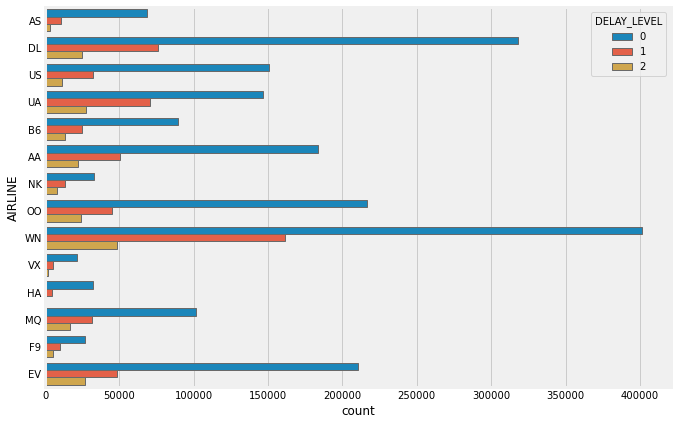

In [5]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [6]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])    
    

In [7]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

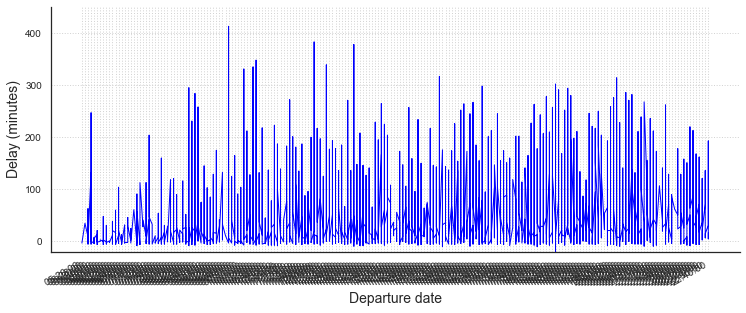

In [8]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
#date_1 = datetime.datetime(2015,1,1)
#date_2 = datetime.datetime(2015,1,15)
#fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-20, 450)

In [37]:
df2 = df
df2['hour_dep'] = df2['SCHEDULED_DEPARTURE'].apply(lambda row: pd.to_datetime(row).hour)
df2.head()

,Unnamed: 0,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_DELAY,SPEED,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements,area,DELAY_LEVEL,hour_dep
0,0,2015-01-01,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,21.0,00:15:00,205.0,1448,04:30:00,-22.0,-11.0,423.805,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west,0,0
1,1,2015-01-01,4,AS,N309AS,ANC,SEA,00:45:00,00:41:00,17.0,00:58:00,204.0,1448,05:09:00,-14.0,-4.0,425.882,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west,0,0
2,2,2015-01-01,4,DL,N3743H,ANC,SEA,00:45:00,00:31:00,25.0,00:56:00,210.0,1448,05:15:00,-24.0,-14.0,413.714,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west,0,0
3,3,2015-01-01,4,AS,N413AS,ANC,PDX,00:50:00,00:46:00,11.0,00:57:00,215.0,1542,05:25:00,-18.0,-4.0,430.326,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west,0,0
4,4,2015-01-01,4,US,N804AW,ANC,PHX,01:52:00,01:43:00,21.0,02:04:00,323.0,2552,09:15:00,-10.0,-9.0,474.056,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,7888,"2,713,843",west,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2818548,2015-06-25,4,B6,N306JB,HYA,JFK,13:09:00,13:15:00,9.0,13:24:00,72.0,196,14:21:00,-12.0,6.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south,1,13
2818549,2818549,2015-06-26,5,B6,N298JB,HYA,JFK,13:09:00,13:15:00,5.0,13:20:00,72.0,196,14:21:00,-18.0,6.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south,1,13
2818550,2818550,2015-06-27,6,B6,N316JB,HYA,JFK,13:09:00,13:08:00,16.0,13:24:00,72.0,196,14:21:00,-7.0,-1.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south,0,13
2818551,2818551,2015-06-29,1,B6,N274JB,HYA,JFK,13:09:00,13:05:00,6.0,13:11:00,72.0,196,14:21:00,-22.0,-4.0,163.333,HYA,Barnstable Municipal Airport,Hyannis,MA,USA,41.66934,-70.28036,12,"31,027",south,0,13


In [38]:
import seaborn as sns
sns.set_theme()

<AxesSubplot:xlabel='hour_dep', ylabel='ARRIVAL_DELAY'>

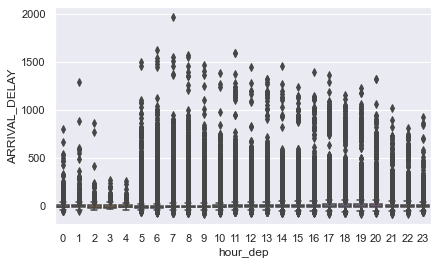

In [65]:
sns.boxplot(x='hour_dep',y='ARRIVAL_DELAY',data=df2)

In [78]:
delayed_df = df2[df2['DELAY_LEVEL'] == 2]

<AxesSubplot:xlabel='hour_dep', ylabel='ARRIVAL_DELAY'>

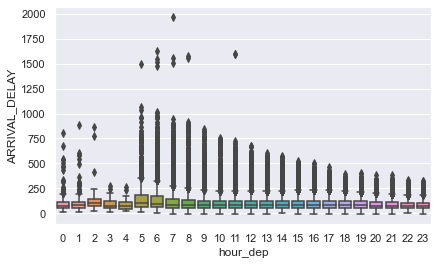

In [79]:
sns.boxplot(x='hour_dep',y='ARRIVAL_DELAY',data=delayed_df)

,Unnamed: 0,DAY_OF_WEEK,TAXI_OUT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DEPARTURE_DELAY,SPEED,LATITUDE,LONGITUDE,Count Flights,DELAY_LEVEL
hour_dep,,,,,,,,,,,,
0,282006.030608,4.000457,14.881377,218.554134,1623.024821,2.211360,7.105680,442.563002,39.873664,-119.621999,68840.615806,0.314146
1,339659.621735,4.049112,14.058168,223.687914,1635.987113,5.062348,7.792407,436.807430,38.830724,-113.738652,62050.411007,0.334727
2,392650.788069,4.018838,12.558870,195.078493,1360.918367,5.833595,7.711146,419.048802,42.206474,-108.016024,14240.433281,0.281005
3,645961.924731,3.951613,12.943548,190.182796,1232.919355,1.620968,8.295699,387.866282,18.322771,-66.689054,3391.526882,0.370968
4,644785.679181,4.058020,11.887372,184.583618,1186.337884,3.600683,8.163823,384.776276,18.363647,-66.530416,5845.904437,0.378840


Text(0.5, 1.0, 'Average arrival delay distribution per hour of the day')

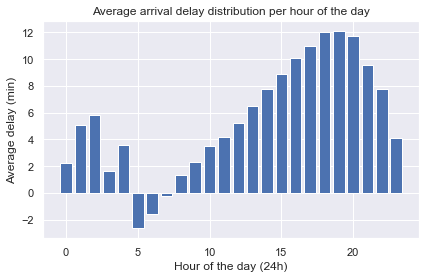

In [70]:
# df_group = df2.groupby('hour_dep').sum()
df_group = df2.groupby('hour_dep').mean()
display(df_group.head())
plt.bar(df_group.index, df_group['ARRIVAL_DELAY'])
plt.xlabel('Hour of the day (24h)')
plt.ylabel('Average delay (min)')
plt.title('Average arrival delay distribution per hour of the day')